# Capstone: Exploratory Prediction Modeling

## Imports & Utilities

### Imports

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


# Import utilities
# import pathlib
import time

# Export dataFrame's as images
import dataframe_image as dfi

# import project utils
import sys
sys.path.append('../src')

import data_utils
from data_utils import Config

import graph_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve

from xgboost import XGBClassifier
import xgboost as xgb

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [5]:
# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

### Utility Functions

In [7]:
def time_secs_to_msg(lapse_time_secs, mins_label='m', secs_label='s'):
    if lapse_time_secs <= 60:
        return f'{lapse_time_secs%60:.2f}{secs_label}'
    else:
        return f'{lapse_time_secs//60:,.0f}{mins_label} {lapse_time_secs%60:.2f}{secs_label}'

In [8]:
def log_optimizer_status_cv(optimizer_results):
    """
    Summarizes optimizer results for each iteration so we can see what params are impactful

    :params optimizer_results: Optimizer data passed in the callback
    """

    iter_num = len(optimizer_results["x_iters"])
    # print(f'... Iteration #{iter_num} Best(score: {optimizer_results["func_vals"][iter_num-1]:,.4f}, best_params: {optimizer_results["x"]})')
    print('... Iteration #{} Best(score: {:,.4f}, best_params: {})'
          .format(iter_num, optimizer_results["func_vals"][iter_num-1], optimizer_results["x"]))
    # print(f'... opt_r={optimizer_results}')

In [9]:
def build_results_row(name, model, Xtr, Xte, ytr, yte, optimizer=None):
    """
    Given the model and training/test sets, builds a row of metrics for reporting the results

    :param name: Name/Description of model
    :param model: Fully constructed model instance - will call fit() and predict() to get metrics
    :param Xtr: X_train - scale before calling
    :param Xte: X_test - scale before calling
    :param ytr: Y_train set
    :param yteL: Y_test set
    :param optimizer: If using CV for optimization, pass in the optimizer here
    """

    if optimizer is None:
        use_best = False
    else:
        use_best = True
        # clf = optimizer
        
    print(f'{name}: Starting (use_best={use_best})', flush=True)
    start_time = time.time()

    # train the model
    clf = None
    if (use_best):
        clf = optimizer.fit(Xtr, ytr, callback=log_optimizer_status_cv)
    else:
        clf = model.fit(Xtr, ytr)
        
    # Save fit time
    fit_time = time.time() - start_time
    logging.debug(f'{name}: Fitted: {fit_time} secs')

    # if we're tuning then use best_estimator
    if use_best:
        clf = optimizer.best_estimator_
        logging.debug(f'{name}: Best Model={clf}')
        logging.debug(f'{name}: Best Params={optimizer.best_params_}')

    # get the predictions / probabilities
    y_preds = clf.predict(Xte)
    y_probs_full = clf.predict_proba(Xte)
    y_probs = y_probs_full[:, 1]

    logging.debug(f'{name}: Got preds/probs')

    cm = confusion_matrix(yte, y_preds)
    logging.debug(f'{name}: cm.shape: {cm.shape}')

    # Get metrics
    row = {
        'Train Time': time_secs_to_msg(fit_time),
        'Train Accuracy': f'{clf.score(Xtr, ytr)*100:.2f}%',
        'Test Accuracy': f'{clf.score(Xte, yte)*100:.2f}%',
        'Precision': f'{precision_score(yte, y_preds, average="weighted")*100:.2f}%',  # for multi-class with imbalance
        'Recall': f'{recall_score(yte, y_preds, average="weighted")*100:.2f}%',
        'F1': f'{f1_score(yte, y_preds, average="weighted")*100:.2f}%',
        'AUC': f'{roc_auc_score(yte, y_probs_full, average="weighted", multi_class="ovr")*100:.2f}%',    # faster with imbalanced multi-class cases
        'LogLoss': f'{log_loss(yte, y_probs_full, labels=np.unique(yte)):.4f}',
        'preds': y_preds,
        'probs': y_probs,
        'cm': cm,
        'params': clf.get_params(),
        'best_params': None,
        'best_model': clf,
    }
    if use_best:
        row.update({'best_params': dict(optimizer.best_params_)})
        
    logging.debug(f'{name}: Got metrics')
    
    print(f'{name}: Done: {time_secs_to_msg(time.time()-start_time)}')

    return row

## The Data: San Francisco Police Department Incident Reports

### Read the Data

We use the utility function `data_utils.select_sample_csv_file()` function to read in the appropriate sampled file for debugging and modeling - the sample percentage selects the appropriate file:

In [13]:
# Which dataset to work from? Select sample size percentage

# sample_file = data_utils.select_sample_csv_file(pct=10)
sample_file = data_utils.select_sample_csv_file(pct=100)
# sample_file = data_utils.select_sample_csv_file(pct=75)
# sample_file = data_utils.select_sample_csv_file(pct=50)
# sample_file = data_utils.select_sample_csv_file(pct=25)

print(f'Selected sample file: {sample_file}')

Selected sample file: ../data/incidents_clean.csv


Read in the pre-cleansed file so we can get to data modeling quickly:

In [15]:
current_raw_df, current_clean_df = data_utils.get_clean_data_from_csv(sample_file)

Reading file: ../data/incidents_clean.csv ... Done: 894,585 rows, 36 columns
... Converting datetime to timeseries ... Done
... Setting index to datetime ... Done
Done


Apply the learnings from the EDA to our data:

In [17]:
data = data_utils.preprocess_data(current_raw_df.copy())

Pre-processing ... 
... Dropping unwanted columns ... 
... preprocess_drop_cols: Column Unnamed: 0 not dropped: KeyError("['Unnamed: 0'] not found in axis")
... preprocess_drop_cols: Column esncag_-_boundary_file dropped
... preprocess_drop_cols: Column central_market/tenderloin_boundary_polygon_-_updated dropped
... preprocess_drop_cols: Column civic_center_harm_reduction_project_boundary dropped
... preprocess_drop_cols: Column hsoc_zones_as_of_2018-06-05 dropped
... preprocess_drop_cols: Column invest_in_neighborhoods_(iin)_areas dropped
... preprocess_drop_cols: Column report_type_code dropped
... preprocess_drop_cols: Column report_type_description dropped
... preprocess_drop_cols: Column filed_online dropped
... preprocess_drop_cols: Column intersection dropped
... preprocess_drop_cols: Column cnn dropped
... preprocess_drop_cols: Column point dropped
... preprocess_drop_cols: Column supervisor_district dropped
... preprocess_drop_cols: Column supervisor_district_2012 dropped
...

In [18]:
# Fix data value artifacts that were discovered during EDA
data = data_utils.fix_data_artifacts(data)

Fixing data artifacts (in-place) ... 
... Category column:
    ..."Human Trafficking*"
    ..."Motor Vehicle Theft"
    ..."Weapons Offence"
Done


In [19]:
data = data_utils.apply_synthetic_features(data)

Generating synthetic feature columns (in-place) ... 
... Adding columns ['hour', 'minute', 'day', 'month']'
... Adding column ['weekend']
... Adding column ['season']
... Adding column ['holiday']
... Adding column ['tod']
Done


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 829328 entries, 2023-03-11 14:00:00 to 2023-03-21 17:42:00
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             829328 non-null  object 
 1   time             829328 non-null  object 
 2   year             829328 non-null  int64  
 3   dow              829328 non-null  object 
 4   category         829328 non-null  object 
 5   resolution       829328 non-null  object 
 6   police_district  829328 non-null  object 
 7   neighborhood     829328 non-null  object 
 8   latitude         829328 non-null  float64
 9   longitude        829328 non-null  float64
 10  hour             829328 non-null  int64  
 11  minute           829328 non-null  int64  
 12  day              829328 non-null  int64  
 13  month            829328 non-null  int64  
 14  weekend          829328 non-null  int64  
 15  season           829328 non-null  object 
 16  holi

## Summary of EDA

After cleaning the data and performing basic EDA, we have established the following:

1. Target variable `category`
   * Evenly spread across time
   * Incidence of crimes is extremely skewed/unbalanced by category. Larceny (29.02%) by far outweighing the other top-10 categories with each being in the single digits
3. Features impacting `category`
   * Affected by incident time and date components: date, time, day of week, month, year, etc
   * Affected by police disctrict
   * Affect by latitude and logitude (TODO: need visualization)
4. Added new synthetic columns like weekends, seasons, holidays, etc to better handle temporal semantics to improve our predictions
5. We artificially removed nulls - here's the logic from our EDA analysis for our decision:
   >We have now gotten rid of most of the unwanted data and most of the columns have **above 94% non-null data**.
   >
   >So far we have found numerous data entry issues that we have fixed above and cleaned the data as much as possible. The remaining data is due to human error and is difficult to "fix" easily. Given that remaining problem samples have missing location information and we could impute those in based on the probabilities across our target variable `category`, it wouldn't change our preiction results because we plan to use log-loss as our evaluation metric, and imputing based on probability will not change the model behavior. We have a sufficiently large amount of training data, with more coming in nightly, so we are going drop all the null rows for now.

We will now proceed with preparing our features for our ML models!

## Feature Engineering

In [24]:
data.head(2)

,date,time,year,dow,category,resolution,police_district,neighborhood,latitude,longitude,hour,minute,day,month,weekend,season,holiday,tod
datetime,,,,,,,,,,,,,,,,,,
2023-03-11 14:00:00,2023/03/11,14:00,2023,Saturday,Assault,Open or Active,Park,Golden Gate Park,37.772895,-122.454285,14,0,11,3,1,Spring,False,Afternoon
2022-06-27 12:00:00,2022/06/27,12:00,2022,Monday,Lost Property,Open or Active,Central,Financial District/South Beach,37.787359,-122.408227,12,0,27,6,0,Summer,False,Afternoon


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 829328 entries, 2023-03-11 14:00:00 to 2023-03-21 17:42:00
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             829328 non-null  object 
 1   time             829328 non-null  object 
 2   year             829328 non-null  int64  
 3   dow              829328 non-null  object 
 4   category         829328 non-null  object 
 5   resolution       829328 non-null  object 
 6   police_district  829328 non-null  object 
 7   neighborhood     829328 non-null  object 
 8   latitude         829328 non-null  float64
 9   longitude        829328 non-null  float64
 10  hour             829328 non-null  int64  
 11  minute           829328 non-null  int64  
 12  day              829328 non-null  int64  
 13  month            829328 non-null  int64  
 14  weekend          829328 non-null  int64  
 15  season           829328 non-null  object 
 16  holi

### Time-based Features

We will now encode our non-numeric features above so that they can be ingested into the models. We use standard encoders and save them so that we can use `inverse_transform` method if needed in our reporting later. 

#### Encoding: Dates

Now let's encode `dow` to numeric values:

In [30]:
enc_dow = LabelEncoder()
enc_dow.fit(data.dow.unique())
data['dow'] = enc_dow.transform(data.dow)

# data[['dow']].head(5)

In [31]:
# Create mask for seasons
seasons = {0:'Winter', 1:'Spring', 2:'Summer', 3:'Fall'}

data['season'] = data.month.map(lambda x: seasons[((x % 12) // 3)])

# data[['month', 'season']].head(5)

Encoding `season`:

In [33]:
enc_season = LabelEncoder()
enc_season.fit(data.season.unique())
data['season'] = enc_season.transform(data.season)

# data[['month', 'season']].head(5)

Done with time-based columns. Let's mark the redundant columns to be dropped after feature engineering:

In [35]:
drop_encoded_cols = ['date', 'time']

Encoding `tod`:

In [37]:
enc_tod = LabelEncoder()
enc_tod.fit(data.tod.unique())
data['tod'] = enc_tod.transform(data.tod)

# data[['hour', 'tod']].head(5)

### Categorical Features

#### Encoding: Resolution

We will also drop the resolution column since it doesn't impact crime prediction:

In [41]:
data.resolution.value_counts()

resolution
Open or Active          662581
Cite or Arrest Adult    166747
Name: count, dtype: int64

In [42]:
drop_encoded_cols.append('resolution')

#### Encoding: Category

In [44]:
enc_cat = LabelEncoder()
enc_cat.fit(data.category.unique())
data.category = enc_cat.transform(data.category)

#### Encoding: Police District

In [46]:
enc_pd = LabelEncoder()
enc_pd.fit(data.police_district.unique())
data['pd'] = enc_pd.transform(data.police_district)

#### Encoding: Neighborhood

In [48]:
enc_hood = LabelEncoder()
enc_hood.fit(data.neighborhood.unique())
data.neighborhood = enc_hood.transform(data.neighborhood)

We are now done with the Categorical features and can now drop the redundant encoded columns that have been converted to other features:

In [50]:
drop_encoded_cols.append('police_district')

print(f'Dropping encoded columns: {drop_encoded_cols}')
data.drop(columns=drop_encoded_cols, inplace=True)

Dropping encoded columns: ['date', 'time', 'resolution', 'police_district']


In [51]:
data.head(2)

,year,dow,category,neighborhood,latitude,longitude,hour,minute,day,month,weekend,season,holiday,tod,pd
datetime,,,,,,,,,,,,,,,
2023-03-11 14:00:00,2023,2,1,7,37.772895,-122.454285,14,0,11,3,1,1,False,0,5
2022-06-27 12:00:00,2022,1,18,5,37.787359,-122.408227,12,0,27,6,0,2,False,0,1


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 829328 entries, 2023-03-11 14:00:00 to 2023-03-21 17:42:00
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          829328 non-null  int64  
 1   dow           829328 non-null  int64  
 2   category      829328 non-null  int64  
 3   neighborhood  829328 non-null  int64  
 4   latitude      829328 non-null  float64
 5   longitude     829328 non-null  float64
 6   hour          829328 non-null  int64  
 7   minute        829328 non-null  int64  
 8   day           829328 non-null  int64  
 9   month         829328 non-null  int64  
 10  weekend       829328 non-null  int64  
 11  season        829328 non-null  int64  
 12  holiday       829328 non-null  bool   
 13  tod           829328 non-null  int64  
 14  pd            829328 non-null  int64  
dtypes: bool(1), float64(2), int64(12)
memory usage: 95.7 MB


In [53]:
# data.to_csv('../data/incidents_10.csv')

## Data Preparation

### Create Train/Test Splits

Before we can train our models, we need to separate out the data into a training and evaluation sets as follows:

1. Use `train_test_split` to get a 80/20% training and evaltion data, stratifying it on the target column
2. From now on, we are careful of using the same random state for data sampling operations
3. One-hot encode the categorical features

In [57]:
X = data.drop('category', axis='columns')
y = data['category']

In [58]:
# OneHot Encode the features and drop the first value to reduce multicollinearity
X = pd.get_dummies(X, drop_first=True)

In [59]:
# Consistent random_state for the project
print(f'Project-wide random_state: {Config.RANDOM_STATE}')

Project-wide random_state: 42


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=Config.RANDOM_STATE)

In [61]:
print('AFTER TRAIN_TEST_SPLIT: Data{}, X_train{}, X_test{}, y_train{}, y_test{}'
      .format(data.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape))

AFTER TRAIN_TEST_SPLIT: Data(829328, 15), X_train(663462, 14), X_test(165866, 14), y_train(663462,), y_test(165866,)


In [62]:
# spot-check feature encoding
X.T.iloc[:, 0:5]

datetime,2023-03-11 14:00:00,2022-06-27 12:00:00,2023-03-16 17:30:00,2023-03-21 15:50:00,2021-08-22 09:40:00
year,2023,2022,2023,2023,2021
dow,2,1,4,5,3
neighborhood,7,5,28,35,26
latitude,37.772895,37.787359,37.76229,37.787038,37.793977
longitude,-122.454285,-122.408227,-122.401324,-122.418271,-122.429804
hour,14,12,17,15,9
minute,0,0,30,50,40
day,11,27,16,21,22
month,3,6,3,3,8
weekend,1,0,0,0,1


### Feature Scaling

For models that require scaled data, we use the `StandardScaler` to scale our data:

In [65]:
# Scale the data - we'll use StandardScaler for the baseline model
logging.debug('Scaling data')
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('AFTER SCALING: Data{}, X_train_scaled{}, X_test_scaled{}, y_train{}, y_test{}'
      .format(data.shape, X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape))

AFTER SCALING: Data(829328, 15), X_train_scaled(663462, 14), X_test_scaled(165866, 14), y_train(663462,), y_test(165866,)


## Model Exploration

The task of classifying the incident types based on a set of historical attrirbutes (features) and predicting on similar attributes is a **multiclass classification** problem. We will now experiment on some ML models that are generally used for similar problems to see what would be the best choice for us.

We will evaluate the following models:

* Simple classification models
  * `DummyClassifier` to get a baseline for our project
  * `LogisticRegression` with L1 Regularization
* Multiclass classifiers
  * `KNeighborsClassifier`
* Ensemble methods: Since our dataset has high variability with a lot of numerical and cagtegorical features with a range of mean and variance, we plan to employ ensemble methods and tune them for best results
  * `RandomForestClassifier`
  * `XGBClassifier`: We considered `XGLite` but selected XGBoost as it provides better model explainability features like SHAP values, which we expect to be able to use in explaining our results

We will now evaluate different models for predicting the Crime Category from our features:

In [69]:
X_train.columns

Index(['year', 'dow', 'neighborhood', 'latitude', 'longitude', 'hour',
       'minute', 'day', 'month', 'weekend', 'season', 'holiday', 'tod', 'pd'],
      dtype='object')

### Evaluation Metrics

In this project, we are predicting or classifyig across 45 crime categories. We will use two evaluation metrics to compare our models:

1. **Accuracy**: Measures the proportion of correct predictions over all predictions made. The accuracy benchmark is 1/45 or 2.22% given our crime categories is a rough benchmark that we will keep in mind. We will try to maximize our classification accuracy
3. **Log_Loss**: Measures the accuracy of a classifier by penalizing false classifications. It does this by taking the negative logarithm of the predicted probability for the true class. The goal is to minimize this loss, meaning that higher probabilities are assigned to the correct classes. Log loss is a powerful way to evaluate not just if the model is making the right predictions, but how confident it is in those predictions. A lower log loss indicates a model that is both accurate and confident and a value of 0 would mean that all predictions were correct!

While accuracy provides a simple measure of correctness, log-loss offers a more nuanced view by considering how confident those predictions are. A model that predicts with 51% confidence for the correct class will have the same accuracy as one that predicts with 99% confidence, but their log loss will be very different. The 99%-confident model will have a much lower log loss.

We'll use them together for a comprehensive evaluation and to learn more about them.

The `build_results_row` utility function will be used to standardize the recording and reporting of our model exploration: 

### Establishing a Baseline

#### DummyClassifier

We will use the Scikit-Learn DummyClassifier method to get a baseline for our predictions using the different strategies provided by the library:

In [76]:
# let's start saving the results for reporting out
results_defaults = {}

# Reports won't print all the columns
report_cols = ['Train Time', 
               'Train Accuracy', 'Test Accuracy', 'LogLoss',
               'Precision', 'Recall', 'F1', 'AUC']

In [77]:
# Define the DummyClassifier models we want to test
models_dummy = {
    'DummyClassifier: uniform': DummyClassifier(strategy='uniform', random_state=Config.RANDOM_STATE),
    'DummyClassifier: most_frequent': DummyClassifier(strategy='most_frequent', random_state=Config.RANDOM_STATE),
    'DummyClassifier: stratified': DummyClassifier(strategy='stratified', random_state=Config.RANDOM_STATE),
}

In [78]:
# logging.getLogger().setLevel(logging.DEBUG)

# Get metrics row for the report - will fit() and predict() to generate metrics
for name, model in models_dummy.items():
    results_defaults[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)

# logging.getLogger().setLevel(logging.INFO)

DummyClassifier: uniform: Starting (use_best=False)
DummyClassifier: uniform: Done: 1.45s
DummyClassifier: most_frequent: Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


DummyClassifier: most_frequent: Done: 1.24s
DummyClassifier: stratified: Starting (use_best=False)
DummyClassifier: stratified: Done: 2.66s


The warning above is from the precision calculation within scikit-learn, and highlights that some labels have no predicted samples, which results in precision being undefined for those labels. We can ignore the warning since we're using accuracy as our key evaluation metric. We could use `prescion_score(zero_division=0)` to suppress the warning, but we'll ignore it instead to ensure we're aware of the condition.

In [80]:
# View results by highest Test Accuracy and lowest log_loss
results_defaults_df = pd.DataFrame(results_defaults).T.sort_values(by=['Test Accuracy', 'LogLoss'], ascending=[False, True])

In [81]:
# format the output to hilite results
hilite=Config.TBL_HILITE_COLOR
results_defaults_styled = results_defaults_df[report_cols].style.map(lambda val: f'background-color: {hilite}',
                                                                     subset=['Test Accuracy','LogLoss'])
results_defaults_styled = results_defaults_styled.set_table_styles({
    'LogLoss': [{'selector': 'th', 'props': [('background-color', hilite)]}],
    'Test Accuracy': [{'selector': 'th', 'props': [('background-color', hilite)]}]
}, overwrite=False)
results_defaults_styled

,Train Time,Train Accuracy,Test Accuracy,LogLoss,Precision,Recall,F1,AUC
DummyClassifier: most_frequent,0.05s,28.93%,28.93%,25.6175,8.37%,28.93%,12.98%,50.00%
DummyClassifier: uniform,0.07s,2.21%,2.21%,3.8067,11.62%,2.21%,3.12%,50.00%
DummyClassifier: stratified,0.05s,11.55%,11.44%,31.9203,11.46%,11.44%,11.45%,49.95%


If you recall, we were using 2.22% (1 out of 45 possible classes) as our blind benchmark, and indeed the `uniform` strategy of the `DummyClassifier` matches that, validating our approach! But the LogLoss result is misleading because 

Since we split our data using stratification on the category column, we can use that as a more realistic benchmark also.

#### Default Models

We will now explore the selected models with out-of-the-box default settings of their hyperparameters to get a baseline per model class.

In [85]:
# Define the default models
models_default = {
    'LogisticRegression (Default)': LogisticRegression(random_state=Config.RANDOM_STATE),
    'KNeighborsClassifier (Default)': KNeighborsClassifier(),
    'RandomForestClassifier (Default)': RandomForestClassifier(random_state=Config.RANDOM_STATE),
    'XGBClassifier (Default)': XGBClassifier(random_state=Config.RANDOM_STATE)
}

In [86]:
# logging.getLogger().setLevel(logging.DEBUG)

# Get metrics row for the report - will fit() and predict() to generate metrics
for name, model in models_default.items():
    results_defaults[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)

# logging.getLogger().setLevel(logging.INFO)

LogisticRegression (Default): Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LogisticRegression (Default): Done: 1m 18.13s
KNeighborsClassifier (Default): Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KNeighborsClassifier (Default): Done: 22m 11.68s
RandomForestClassifier (Default): Starting (use_best=False)
RandomForestClassifier (Default): Done: 7m 31.95s
XGBClassifier (Default): Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBClassifier (Default): Done: 4m 2.16s


In [87]:
# View results by highest Test Accuracy and lowest log_loss
results_defaults_df = pd.DataFrame(results_defaults).T.sort_values(by=['Test Accuracy', 'LogLoss'], ascending=[False, True])

In [88]:
# format the output to hilite results
hilite=Config.TBL_HILITE_COLOR
results_defaults_styled = results_defaults_df[report_cols].style.map(lambda val: f'background-color: {hilite}',
                                                                     subset=['Test Accuracy','LogLoss'])
results_defaults_styled = results_defaults_styled.set_table_styles({
    'LogLoss': [{'selector': 'th', 'props': [('background-color', hilite)]}],
    'Test Accuracy': [{'selector': 'th', 'props': [('background-color', hilite)]}]
}, overwrite=False)
results_defaults_styled

,Train Time,Train Accuracy,Test Accuracy,LogLoss,Precision,Recall,F1,AUC
RandomForestClassifier (Default),3m 53.05s,87.94%,33.93%,5.5970,28.38%,33.93%,28.89%,71.70%
XGBClassifier (Default),3m 20.90s,35.96%,33.69%,2.3756,27.72%,33.69%,24.69%,74.46%
LogisticRegression (Default),1m 15.56s,29.28%,29.29%,2.6273,13.92%,29.29%,14.92%,63.87%
DummyClassifier: most_frequent,0.05s,28.93%,28.93%,25.6175,8.37%,28.93%,12.98%,50.00%
KNeighborsClassifier (Default),1.46s,43.91%,24.53%,18.9323,19.59%,24.53%,20.67%,60.81%
DummyClassifier: uniform,0.07s,2.21%,2.21%,3.8067,11.62%,2.21%,3.12%,50.00%
DummyClassifier: stratified,0.05s,11.55%,11.44%,31.9203,11.46%,11.44%,11.45%,49.95%


In [89]:
# Save results to file for final report
if not Config.SUPPRESS_OUTPUT_FILES:
    dfi.export(results_defaults_styled, Config.IMAGE_DIR / 'table_models_defaults.png')

### Candidate Models

Adding other commercial-grade ML models that are know to do well on multi-class classification problems, and using them with their out-of-the-box settings, we see that the following models are candidates for further investigation based on their Accuracy and LogLoss scores:

1. RandomForestClassifier
2. XGBClassifier
3. LogisticRegression

We will now test them using best-guess parameters to see how to proceed further as the training time on XGB will be considerable on our large dataset and it would be good to narrow down the field before proceed to brute-force hyperparameter tuning. 

In [92]:
# parameters
VERBOSE=0             # 0: None, 1: Iteration end, 2: Iteration scores
JOBS=-1               # Use all cores

In [93]:
# let's start saving the results for reporting out
results_tuned = {}

# Reports won't print all the columns
report_cols_tuned = [#'params', 
                     'Train Time', 'Train Accuracy', 'Test Accuracy', 'LogLoss',
                     'Precision', 'Recall', 'F1', 'AUC']

In [94]:
# Define the candidate models with starting params
models_tuned = {
    
    'LogisticRegression': LogisticRegression(penalty='l1', solver='saga', max_iter=1000, 
                                             verbose=VERBOSE, n_jobs=JOBS, random_state=Config.RANDOM_STATE),

    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=15,
                                                     min_samples_leaf=5, min_samples_split=25, 
                                                     random_state=Config.RANDOM_STATE, 
                                                     verbose=VERBOSE, n_jobs=JOBS),

    'XGBClassifier': XGBClassifier(n_estimators=100, objective="multi:softprob", 
                                   n_jobs=JOBS, random_state=Config.RANDOM_STATE),
}

In [95]:
# logging.getLogger().setLevel(logging.DEBUG)

print(f'Settings: verbose={VERBOSE}, n_jobs={JOBS}')

# Get metrics row for the report - will fit() and predict() to generate metrics
for name, model in models_tuned.items():
    results_tuned[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test)

# logging.getLogger().setLevel(logging.INFO)

Settings: verbose=0, n_jobs=-1
LogisticRegression: Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LogisticRegression: Done: 6m 27.23s
RandomForestClassifier: Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RandomForestClassifier: Done: 1m 10.65s
XGBClassifier: Starting (use_best=False)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBClassifier: Done: 3m 56.77s


In [96]:
# View results by highest Test Accuracy and lowest log_loss
results_tuned_df = pd.DataFrame(results_tuned).T.sort_values(by=['Test Accuracy', 'LogLoss'], ascending=[False, True])

In [97]:
# format the output to hilite results
hilite=Config.TBL_HILITE_COLOR
results_tuned_styled = results_tuned_df[report_cols_tuned].style.map(lambda val: f'background-color: {hilite}', 
                                                                     subset=['Test Accuracy','LogLoss'])
results_tuned_styled = results_tuned_styled.set_table_styles({
    'params': [{'selector': 'td', 'props': [('max-width', '300px'), 
                                  ('white-space', 'normal'), 
                                  ('word-wrap', 'break-word')]}],
    'LogLoss': [{'selector': 'th', 'props': [('background-color', hilite)]}],
    'Test Accuracy': [{'selector': 'th', 'props': [('background-color', hilite)]}]
}, overwrite=False)
results_tuned_styled

,Train Time,Train Accuracy,Test Accuracy,LogLoss,Precision,Recall,F1,AUC
XGBClassifier,3m 15.69s,35.96%,33.69%,2.3756,27.72%,33.69%,24.69%,74.46%
RandomForestClassifier,50.77s,34.99%,32.48%,2.4232,25.69%,32.48%,20.63%,73.62%
LogisticRegression,6m 24.62s,29.28%,29.29%,2.6273,14.01%,29.29%,14.92%,63.87%


In [98]:
# Save results to file for final report
if not Config.SUPPRESS_OUTPUT_FILES:
    dfi.export(results_tuned_styled, Config.IMAGE_DIR / 'table_models_tuned.png')

Looking at the above results, we see major improvements in the XGB and RandomForest LogLoss scores, with the two ensemble models beating LogisticRegression as expected. So, we will proceed the top two contenders from now.

## Model Hyperparameter Tuning

### BayesSearchCV

We are now ready to tune models with a more comprehensive optimization of their training parameters. We looked at brute-force GridSearchCV and Randomized Parameter Optimization, but based on literature search, decided to use `BayesSearchCV` because it uses the results from previous optimization attempts to inform subsequent attempts. It builds a probability model of the objective function, mapping the input values to the probability of a loss. This surrogate model is easier to optimize than the actual objective function and allows `BayesSearchCV` to select the next hyperparameter combination. More time is spent in selecting the next optimization parameters than brutely trying them all out.

Our model selection run will:

* Stratified 3-Fold cross validation
* We are only using 5 iterations due to the limitation of our hardware given the large dataset

During the initial optimization runs, we tuned the parameters if the model didn't converge or took too long. The hyperparameters that were considered in the final tuning run can be seen in the `model_search_spaces` dictionary below.

In [103]:
# BayesSearchCV Tuning parameters
CV=3             # cross-validation splitting strategy: StratifiedKFold=3
VERBOSE=0        # 0: None, 1: Iteration end, 2: Iteration scores
JOBS=-1          # Use all cores
ITERATIONS=5     # Num of param settings that are sampled. Trades off runtime vs quality of the solution
# ITERATIONS=2     # Num of param settings that are sampled. Trades off runtime vs quality of the solution

In [104]:
# let's start saving the results for reporting out
results_CV = {}

# Reports won't print all the columns
report_cols_CV = ['best_params', 'Train Time', 
                  'Train Accuracy', 'Test Accuracy', 'LogLoss',
                  'Precision', 'Recall', 'F1', 'AUC']

In [105]:
# Initialize our models for BayesSearchCV
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=Config.RANDOM_STATE),
    'XGBClassifier': XGBClassifier(objective="multi:softprob", random_state=Config.RANDOM_STATE),
}

# Define the search spaces for hyperparameter tuning 
model_search_spaces = {
    
    # Define search spaces for RandomForestClassifier
    'RandomForestClassifier': {
        'n_estimators': Integer(50, 100),
        'max_depth': Integer(3, 20),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 10),
        'max_features': Categorical(['sqrt', 'log2', None]),       # None=n_features
    },
    
    # Define search spaces for XGBClassifier
    'XGBClassifier': {
        'n_estimators': Integer(50, 1000),
        'max_depth': Integer(3, 100),
        'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
        'min_child_weight': Integer(1, 10),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
    }
}

In [106]:
# logging.getLogger().setLevel(logging.DEBUG)

# Get metrics row for the report - will fit() and predict() to generate metrics
for name, model in models.items():
    
    print(f'{name}: Starting BayesSearchCV optimization ({CV}-fold)', flush=True)
    print(f'Settings: verbose={VERBOSE}, n_jobs={JOBS}, cv={CV}, n_iter={ITERATIONS}')
    
    opt = BayesSearchCV(
        estimator=model,
        search_spaces=model_search_spaces[name],
        scoring = 'neg_log_loss',
        n_iter=ITERATIONS,
        cv=CV,
        n_jobs=JOBS,
        random_state=Config.RANDOM_STATE,
        verbose=VERBOSE
    )

    results_CV[name] = build_results_row(name, model, X_train_scaled, X_test_scaled, y_train, y_test, optimizer=opt)

    print(f'{name}: Done BayesSearchCV optimization ({CV}-fold)', flush=True)

# logging.getLogger().setLevel(logging.INFO)

RandomForestClassifier: Starting BayesSearchCV optimization (3-fold)
Settings: verbose=0, n_jobs=-1, cv=3, n_iter=5
RandomForestClassifier: Starting (use_best=True)
... Iteration #1 Best(score: 2.5066, best_params: [10, None, 9, 8, 84])
... Iteration #2 Best(score: 2.4714, best_params: [17, None, 4, 19, 93])
... Iteration #3 Best(score: 2.4935, best_params: [17, None, 4, 19, 93])
... Iteration #4 Best(score: 2.4373, best_params: [17, 'sqrt', 6, 16, 76])
... Iteration #5 Best(score: 2.4287, best_params: [17, 'log2', 6, 15, 95])


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


RandomForestClassifier: Done: 17m 33.45s
RandomForestClassifier: Done BayesSearchCV optimization (3-fold)
XGBClassifier: Starting BayesSearchCV optimization (3-fold)
Settings: verbose=0, n_jobs=-1, cv=3, n_iter=5
XGBClassifier: Starting (use_best=True)
... Iteration #1 Best(score: 3.1570, best_params: [0.4160029192647807, 0.8638628715886625, 0.2387586688716479, 34, 7, 443, 1.440064730980368e-06, 0.7482570377261556, 0.6522316555182531])
... Iteration #2 Best(score: 2.4562, best_params: [0.8390144719977516, 0.9416576386904312, 0.02806554771929606, 95, 9, 109, 1.7570205641667407e-08, 1.7500432085329334e-05, 0.8178645509395852])
... Iteration #3 Best(score: 2.3942, best_params: [0.4503841871781403, 0.9593612608346885, 0.014285310742471472, 45, 3, 481, 2.506296724099989e-08, 1.0438314460187998, 0.7786702115169006])
... Iteration #4 Best(score: 2.3532, best_params: [0.8142720284737898, 0.5859357806982803, 0.07645185888630145, 81, 6, 141, 0.006341686887862837, 29.618580433942107, 0.9559644307

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBClassifier: Done: 267m 6.38s
XGBClassifier: Done BayesSearchCV optimization (3-fold)


In [107]:
# View results by highest Test Accuracy and lowest log_loss
results_CV_df = pd.DataFrame(results_CV).T.sort_values(by=['Test Accuracy', 'LogLoss'], ascending=[False, True])

In [108]:
# format the output to hilite results
hilite=Config.TBL_HILITE_COLOR
results_CV_styled = results_CV_df[report_cols_CV].style.map(lambda val: f'background-color: {hilite}', 
                                                                     subset=['Test Accuracy','LogLoss'])
results_CV_styled = results_CV_styled.set_table_styles({
    'best_params': [{'selector': 'td', 'props': [('max-width', '300px'), 
                                                 ('white-space', 'normal'), 
                                                 ('word-wrap', 'break-word')]}],
    'LogLoss': [{'selector': 'th', 'props': [('background-color', hilite)]}],
    'Test Accuracy': [{'selector': 'th', 'props': [('background-color', hilite)]}]
}, overwrite=False)

results_CV_styled

,best_params,Train Time,Train Accuracy,Test Accuracy,LogLoss,Precision,Recall,F1,AUC
XGBClassifier,"{'colsample_bylevel': 0.8142720284737898, 'colsample_bytree': 0.5859357806982803, 'learning_rate': 0.07645185888630145, 'max_depth': 81, 'min_child_weight': 6, 'n_estimators': 141, 'reg_alpha': 0.006341686887862837, 'reg_lambda': 29.618580433942107, 'subsample': 0.9559644307534418}",262m 15.76s,49.00%,35.01%,2.3240,29.64%,35.01%,26.50%,76.30%
RandomForestClassifier,"{'max_depth': 17, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 95}",16m 51.69s,38.68%,33.16%,2.4043,30.79%,33.16%,21.99%,74.28%


In [109]:
# Save results to file for final report
if not Config.SUPPRESS_OUTPUT_FILES:
    dfi.export(results_CV_styled, Config.IMAGE_DIR / 'table_models_CV.png')

## Best Model Evaluation

In [111]:
# Print results for the best-model selected by the optimizer
best_model = opt.best_estimator_
best_model_idx = [name for name, model in models.items() if results_CV[name]['best_model'] == best_model][0]
target_names = np.unique(enc_cat.inverse_transform(data.category))

print('\n\nBest Model:\n\t{}\n\tTest Accuracy: {}\n\tLog-Loss: {}\n\tBest Params: {}\n\nClassification Report:\n\n{}'
      .format(best_model_idx, 
              results_CV[best_model_idx]['Test Accuracy'],
              results_CV[best_model_idx]['LogLoss'],
              results_CV[best_model_idx]['best_params'],
              classification_report(y_test, 
                                    results_CV[best_model_idx]['preds'],
                                    target_names=target_names
                                   ),
             ),
      flush=True
     )

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




Best Model:
	XGBClassifier
	Test Accuracy: 35.01%
	Log-Loss: 2.3240
	Best Params: {'colsample_bylevel': 0.8142720284737898, 'colsample_bytree': 0.5859357806982803, 'learning_rate': 0.07645185888630145, 'max_depth': 81, 'min_child_weight': 6, 'n_estimators': 141, 'reg_alpha': 0.006341686887862837, 'reg_lambda': 29.618580433942107, 'subsample': 0.9559644307534418}

Classification Report:

                                          precision    recall  f1-score   support

                                   Arson       0.00      0.00      0.00       511
                                 Assault       0.21      0.19      0.20     10974
                                Burglary       0.31      0.20      0.24      9827
                            Case Closure       0.17      0.01      0.03       369
                         Civil Sidewalks       0.43      0.57      0.49       177
                         Courtesy Report       0.00      0.00      0.00       154
                      Disorderly 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion Matrix

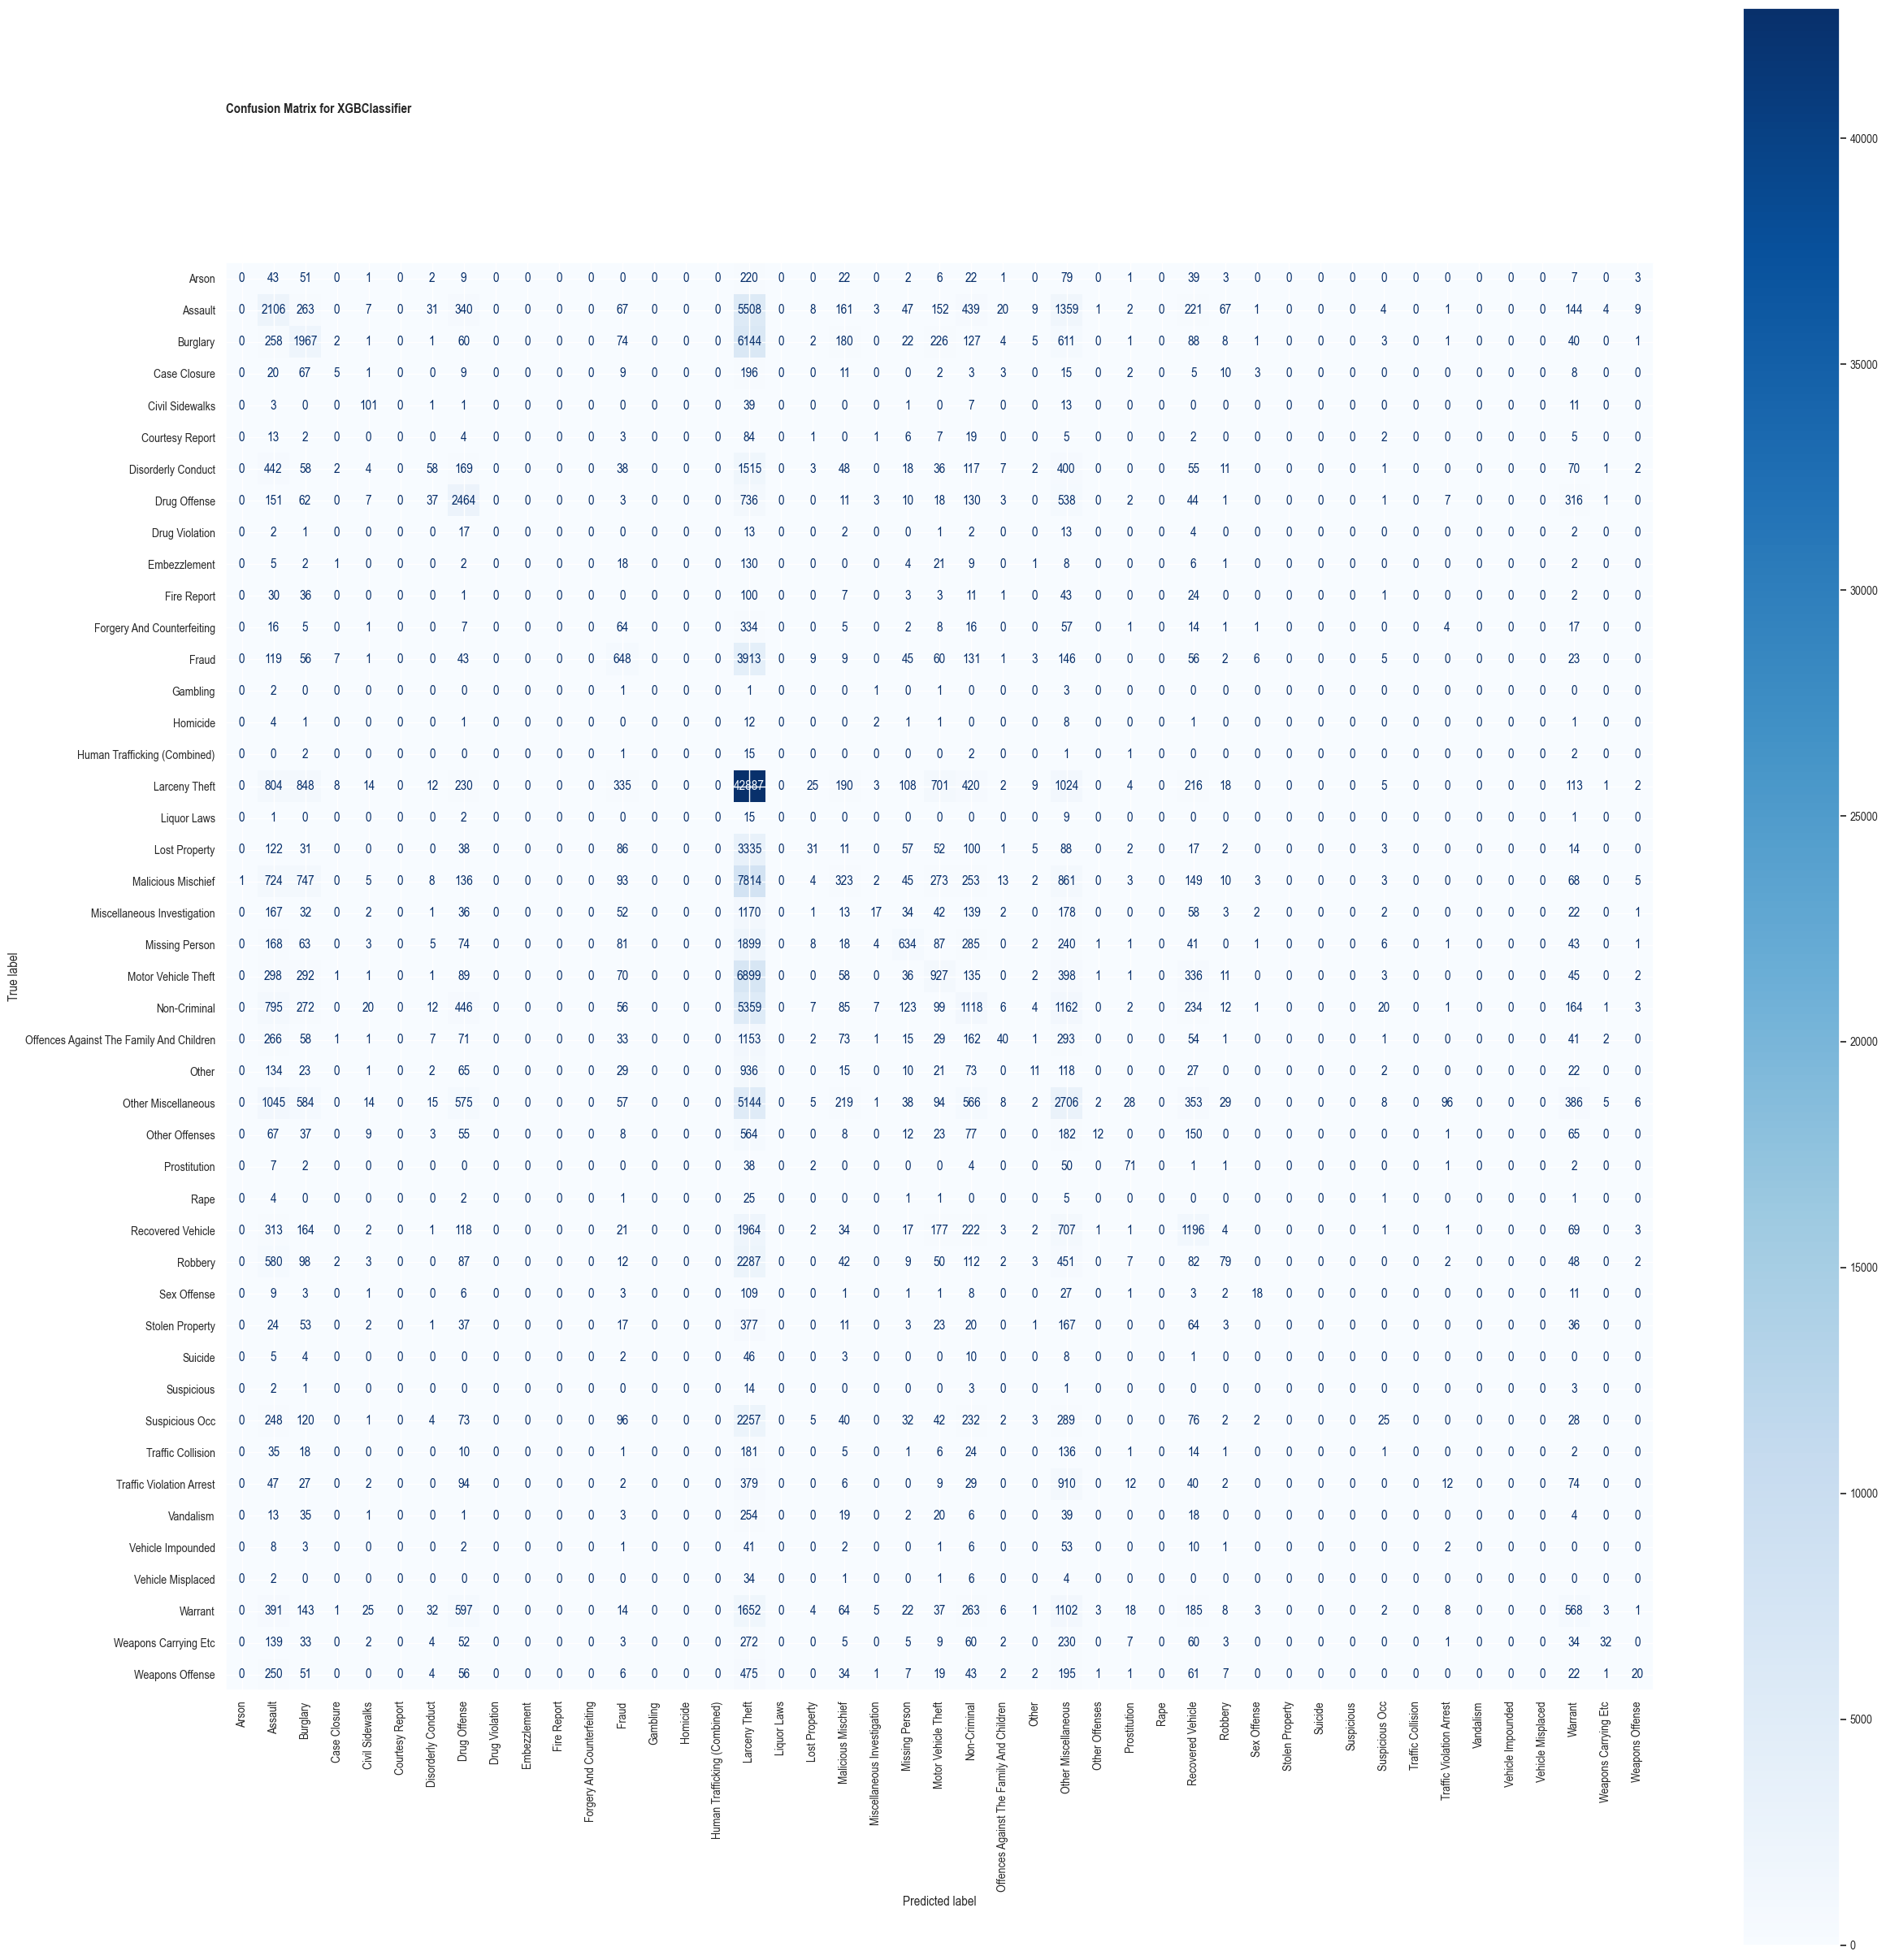

In [113]:
# for name, model in models.items():
plt.rcParams.update({
    # "font.family": "Roboto Condensed"
    "font.family": "Arial Narrow",
    "figure.titlesize": "x-large",
})
for name, model in {best_model_idx : best_model}.items():
    # disp = ConfusionMatrixDisplay(results_CV[name]['cm'], display_labels=target_names, )

    # Generate the confusion matrix
    fig, ax = plt.subplots(figsize=(25, 25))
    # disp.plot(ax=ax)
    ConfusionMatrixDisplay.from_predictions(y_test, results_CV[best_model_idx]['preds'], ax=ax, cmap=plt.cm.Blues,
                                            display_labels=target_names, xticks_rotation='vertical')
    plt.tight_layout()
    ax.set_title(f'Confusion Matrix for {name}', loc="left", fontdict={"weight": "bold"}, y=1.1)
    plt.savefig(Config.IMAGE_DIR / f'Confusion_matrix_{name}.png')
    plt.show()

### Feature Importance

Next we look at the relative importance the model gave to each feature as it learnt during the training process. The goal would be to remove any features that are not factoring into the model predictions, thereby improving the overall model. Under normal circumstances, we would have removed anything below 1% contribution, but most of our features are being used and given the low classification benchmark per class, I will leave them all for now.

It is also notable that all the syntheitc features, like holidays and time of day `tod`, that we added during the feature engineering phase are being used in the prediction process! If you look at the XGB decision tree below, the shallow depth reflects this feature importance distribution.

In [116]:
# Get the importance features as scored by the best_model
feature_importances = best_model.feature_importances_
        
# Normalize the feature importances
feature_importances = feature_importances / feature_importances.sum()
    
# Create a DataFrame with feature names and importances
imp_table = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
imp_table = imp_table.sort_values('Importance', ascending=False).reset_index(drop=True)

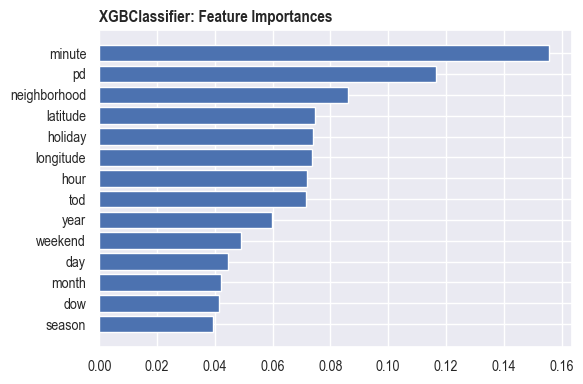

In [117]:
# Visualize feature importances
plt.figure(figsize=(6,4))

plt.barh(imp_table['Feature'], imp_table['Importance'])#, color='skyblue')
# ax.set_xlabel('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top

plt.title(f'{best_model_idx}: Feature Importances', loc="left", fontdict={"weight": "bold"})

# Adjust layout to prevent overlap
plt.tight_layout()

if not Config.SUPPRESS_OUTPUT_FILES:
    plt.savefig(Config.IMAGE_DIR / 'best_feature_importances.png')

plt.show()

In [118]:
# %%time
# plt.figure(figsize=(8,4))
# xgb.plot_importance(best_model)
# # plt.title(f'{best_model_idx}: xgboost.plot_importance', loc="left", fontdict={"weight": "bold"}, y=1.0)
# plt.show()

I'm using an out-of-the-box utility provided with XGB that gives insight into it's training. Here, we can see that the XGB-generated tree is fairly shallow, so the model did well. This can be used for the next iteration of tuning and business recommendations.

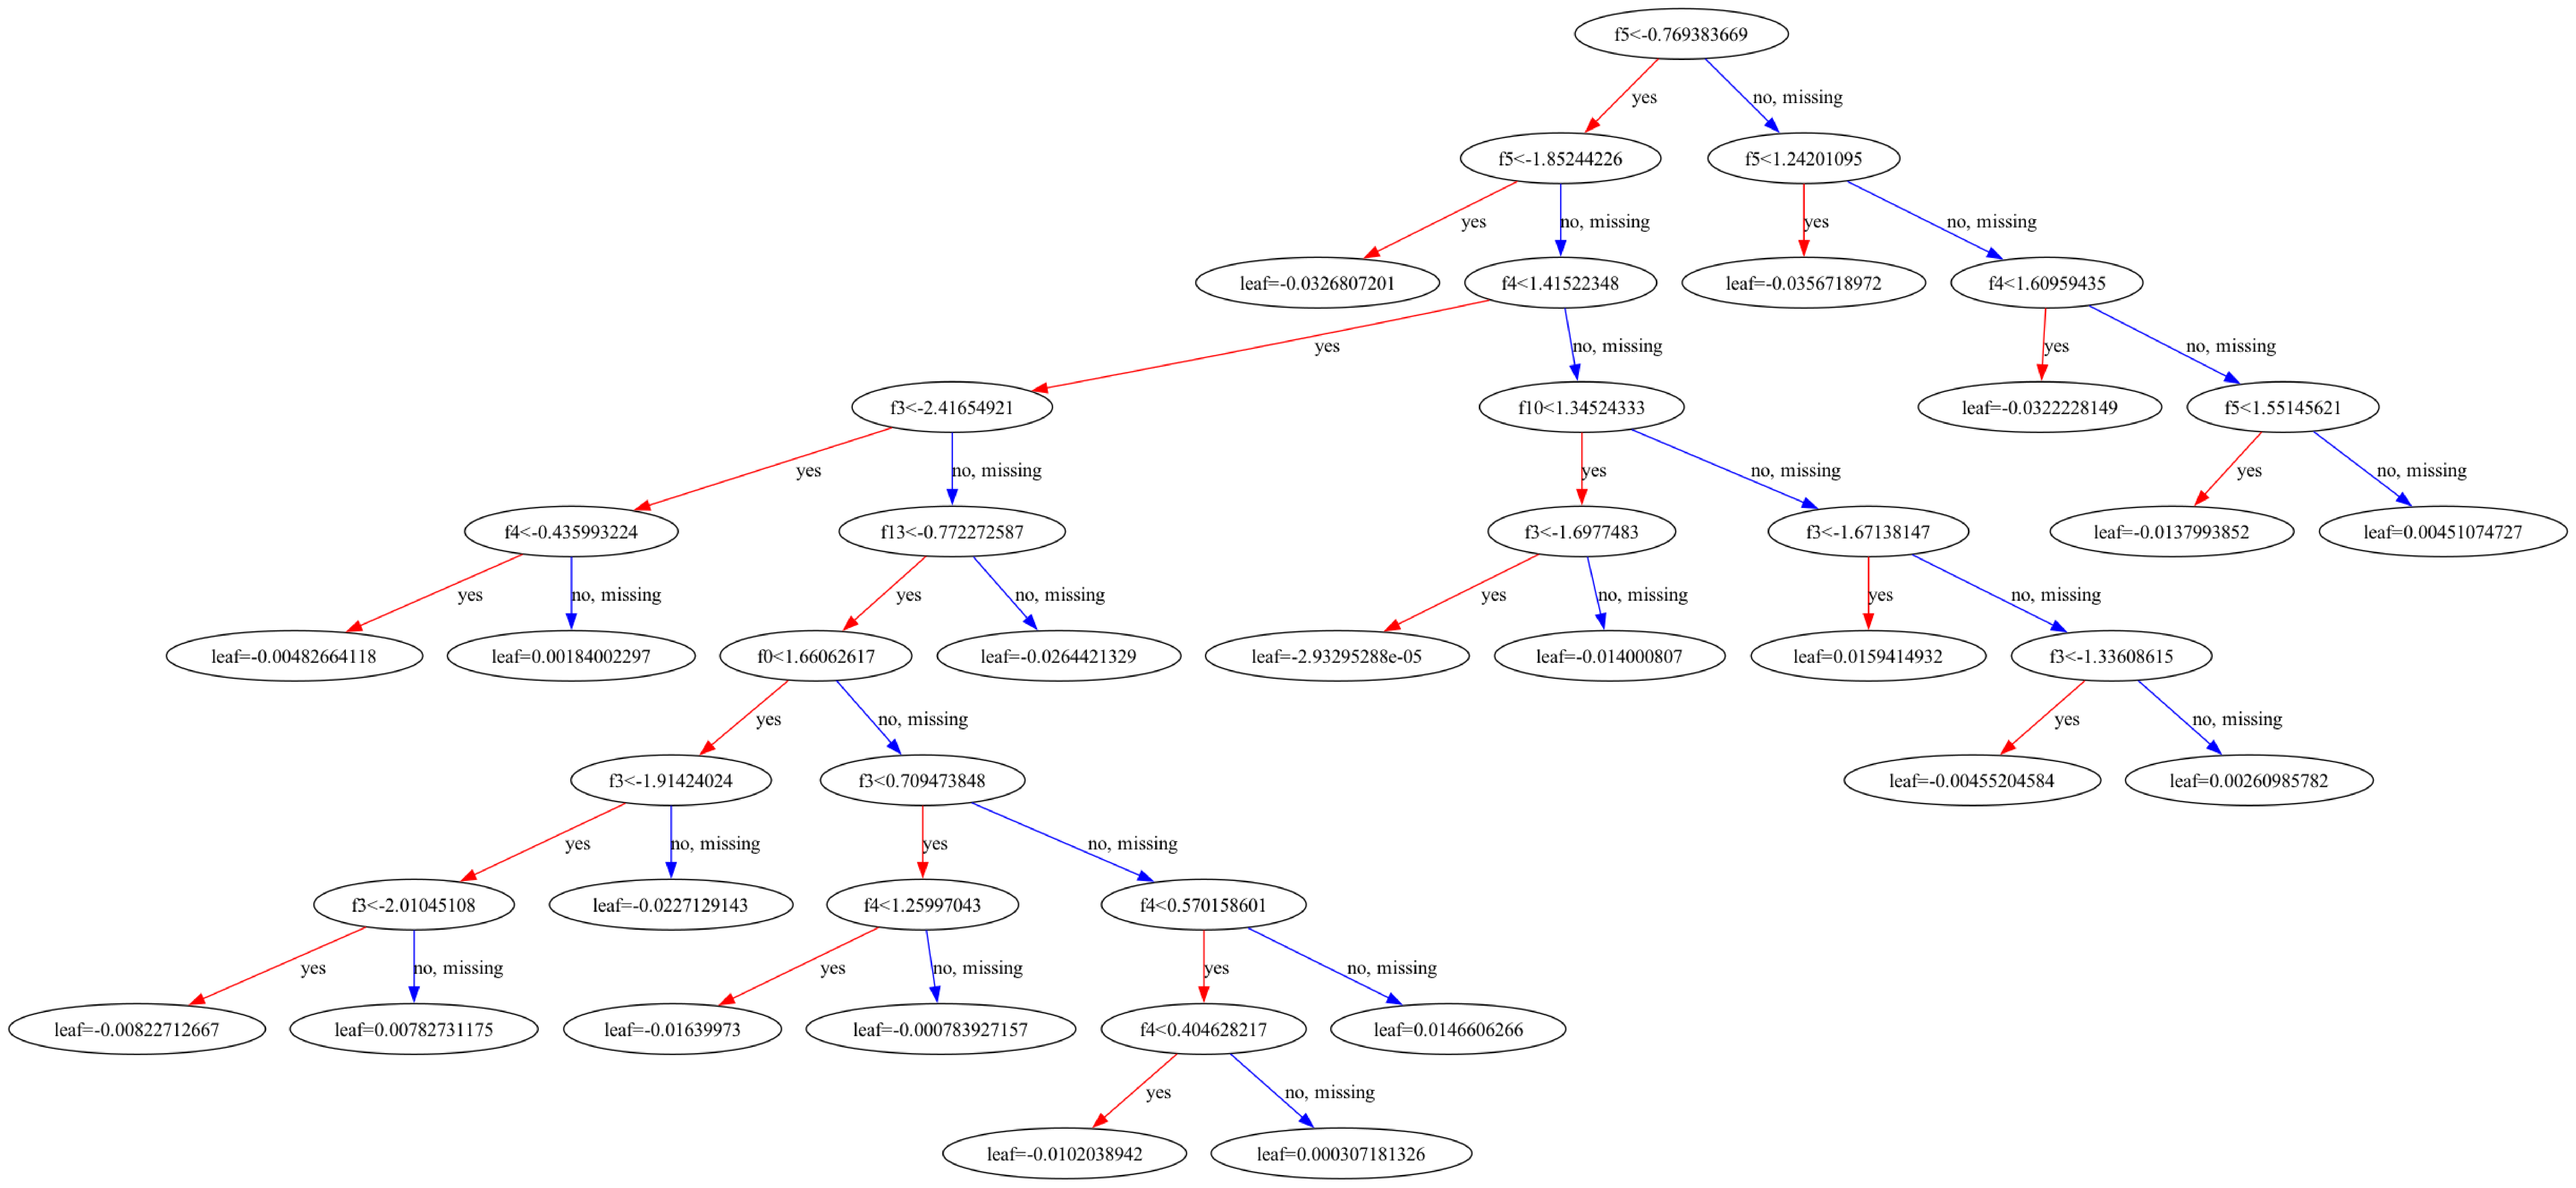

CPU times: user 1min 14s, sys: 7.03 s, total: 1min 21s
Wall time: 33.5 s


In [120]:
%%time
fig, ax = plt.subplots(figsize=(100, 100))
xgb.plot_tree(best_model, ax=ax)

# plt.title(f'{best_model_idx}: Decision Tree', loc="left", fontdict={"weight": "bold"}, y=1.0)

plt.savefig(Config.IMAGE_DIR / 'xgbtree.png')
plt.show()

### Results Tabulation

Let's create a table to report our overall results tally in a readable format - it looks a little ugly but will make the case for the tuning!

In [678]:
# Define the multiIndex for the results tally
models = ['XGBClassifier', 'RandomForestClassifier', 'LogisticRegression', 'KNeighborsClassifier', 'DummyClassifier: stratified']
headings_l1 = ['Baseline', 'Default Params', 'Tuned Params', 'Improvement']
headings_l2 = ['Accuracy','LogLoss']
results_cols = ['Test Accuracy','LogLoss']

results_tally = pd.DataFrame([],
                             index=pd.Index(models, name='Model'),
                             columns=pd.MultiIndex.from_product([headings_l1, headings_l2])
                            )
# results_tally

In [680]:
# Load results from Baseline Run
col = 0
for model in models:
    modelname = model if model.startswith('DummyClassifier') else f'{model} (Default)'
    results_tally.loc[model, (headings_l1[col], headings_l2[0])] = results_defaults[modelname][results_cols[0]]
    results_tally.loc[model, (headings_l1[col], headings_l2[1])] = results_defaults[modelname][results_cols[1]]


# Load results from Default Params Run

models.remove('DummyClassifier: stratified')
models.remove('KNeighborsClassifier')

col = 1
for model in models:
    results_tally.loc[model, (headings_l1[col], headings_l2[0])] = results_tuned[model][results_cols[0]]
    results_tally.loc[model, (headings_l1[col], headings_l2[1])] = results_tuned[model][results_cols[1]]

# Load results from Params Tuning Run

models.remove('LogisticRegression')

col = 2
for model in models:
    results_tally.loc[model, (headings_l1[col], headings_l2[0])] = results_CV[model][results_cols[0]]
    results_tally.loc[model, (headings_l1[col], headings_l2[1])] = results_CV[model][results_cols[1]]


# Calculate the Improvement %-age
for model in ['XGBClassifier', 'RandomForestClassifier']:
    acc_col0 = float(results_tally.loc[model, (headings_l1[0], headings_l2[0])].removesuffix('%'))
    acc_col2 = float(results_tally.loc[model, (headings_l1[2], headings_l2[0])].removesuffix('%'))
    ll_col0 = float(results_tally.loc[model, (headings_l1[0], headings_l2[1])])
    ll_col2 = float(results_tally.loc[model, (headings_l1[2], headings_l2[1])])

    results_tally.loc[model, (headings_l1[3], headings_l2[0])] = f'{(np.abs(acc_col0 - acc_col2) / acc_col0) * 100:,.2f}%'
    results_tally.loc[model, (headings_l1[3], headings_l2[1])] = f'{(np.abs(ll_col0 - ll_col2) / ll_col0) * 100:,.2f}%'

In [682]:
# Replace all NaN values with a blank string
results_tally.fillna('', inplace=True)

In [684]:
# Apply styling to center the text and headers
results_tally_styled = results_tally.style.set_properties(subset=headings_l1, 
                                                          **{'text-align': 'center'}
                                                         ).set_table_styles([{'selector': 'th',  # for headers
                                                                              'props': [('text-align', 'center')],
                                                                             }])

results_tally_styled

In [686]:
# Save results to file for final report
if not Config.SUPPRESS_OUTPUT_FILES:
    dfi.export(results_tally_styled, Config.IMAGE_DIR / 'table_results_tally.png')

### SHAP: Model Explanation

In [690]:
import shap

In [696]:
%%time

explainer = shap.TreeExplainer(best_model, feature_names=target_names)

CPU times: user 44.4 s, sys: 16.9 s, total: 1min 1s
Wall time: 1min 42s


In [698]:
# Create a sample set of the first n test values
sample_first_20 = X_test.iloc[0:20]

In [700]:
%%time

# Get SHAP values for the first 20 test samples

# shap_values = explainer.shap_values(X_test)
shap_values = explainer.shap_values(sample_first_20)

CPU times: user 55.6 s, sys: 1.97 s, total: 57.6 s
Wall time: 30.6 s


In [704]:
shap.initjs()

In [706]:
%%time

# Let's look at first sample

shap.force_plot(explainer.expected_value[0], shap_values[0][:,0], features=X_train.columns)

CPU times: user 324 µs, sys: 1e+03 ns, total: 325 µs
Wall time: 334 µs


In [708]:
%%time

# Let's look at last sample
shap.force_plot(explainer.expected_value[-1], shap_values[-1][:,0], features=X_train.columns)

CPU times: user 353 µs, sys: 1e+03 ns, total: 354 µs
Wall time: 363 µs


In [710]:
%%time

# Let's look at all the 20 samples together

shap.force_plot(explainer.expected_value[0], shap_values[:,0], feature_names=X_train.columns, )

CPU times: user 7.99 ms, sys: 4.32 ms, total: 12.3 ms
Wall time: 84.5 ms


In [712]:
# Create a sample set of just Larceny Theft

sample_larceny = X_test.loc[y_test == 16]

In [720]:
# n = 20
n = int(len(sample_larceny) * 0.05)   # 5%
# n = len(sample_larceny)            # All

print(f'Sample size for Larceny: {n}')

Sample size for Larceny: 479


In [716]:
%%time

# Get SHAP values for the first n test samples

# shap_values = explainer.shap_values(X_test)
shap_values = explainer.shap_values(sample_larceny.head(n))

CPU times: user 1h 51min 10s, sys: 27 s, total: 1h 51min 37s
Wall time: 35min 37s


In [717]:
%%time

# Let's look at all the 20 samples together

# shap.force_plot(exp.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])
shap.force_plot(explainer.expected_value[0], shap_values[:,0], features=X_train.columns)#, feature_names=target_names)#, feature_names=X_train.columns)

CPU times: user 58.2 s, sys: 578 ms, total: 58.7 s
Wall time: 59.6 s


## Deployment & Implementation

### Save Model

We will now save the fitted models so that we can use them at a later point to make predictions. We will encode the saved model file with information on the input file used and the date and time stamp so we can infer the training procedure from the filename.

In [124]:
import datetime
import joblib

# Get the basename of the data input file used for training
sample_file_basename=sample_file.replace('.csv', '').split('/')[-1]
sample_file_basename

'incidents_clean'

In [125]:
saved_file_list = {}

for name, model in models.items():

    # Generate the Pickle filename encoded with the sample file and timestamp
    now = datetime.datetime.now()
    model_filename = Config.MODELS_DIR / f'saved_{name}_{sample_file_basename}_{now.strftime("%Y-%m-%d")}_{now.strftime("%H%M")}.pkl'
    print(f'Saving model: {name} -> filename: {model_filename}')

    # Save the best model to a file
    joblib.dump(best_model, model_filename)

    saved_file_list[name] = {'savefile': model_filename}

Saving model: RandomForestClassifier -> filename: ../models/saved_RandomForestClassifier_incidents_clean_2024-10-15_0443.pkl
Saving model: XGBClassifier -> filename: ../models/saved_XGBClassifier_incidents_clean_2024-10-15_0443.pkl


### Load & Test Saved Model

Now we will load the saved files and do some test predictions to test them out similar to how these models would be used during production deployment.

In [128]:
def make_prediction(model, input_df):
    """
    Predict crime category

    :param model: Trained model
    :param input_df: [num_samples x num_features] DataFrame containing the input features for the prediction

    :returns: Prediction from the model
    """
    
    # Valid input columns against X_train
    sample_df = input_df[X_train.columns]

    # Make predictions
    return model.predict(sample_df)

In [129]:
# Creating a sample manually
sample_dict = {
    'year': 2019,
    'dow': 0,
    'neighborhood': 18,
    'latitude': 37.76511715805121,
    'longitude': -122.4185791393267,
    'hour': 21,
    'minute': 0,
    'day': 27,
    'month': 9,
    'weekend': 0,
    'season': 0,
    'holiday': False,
    'tod': 1,
    'pd': 3
}

sample = pd.DataFrame(data=sample_dict, index=range(1))
sample

,year,dow,neighborhood,latitude,longitude,hour,minute,day,month,weekend,season,holiday,tod,pd
0,2019,0,18,37.765117,-122.418579,21,0,27,9,0,0,False,1,3


In [130]:
for mname, model in saved_file_list.items():
    print(f'\nLoading saved {mname} file: {model["savefile"]}')

    loaded_model = joblib.load(model["savefile"])

    # test with a manually created sample
    print(f'Prediction Results single sample: {make_prediction(loaded_model, sample)}', flush=True)

    # test from X_test[0]
    print(f'Prediction Results X_test[0]: {make_prediction(loaded_model, X_test.iloc[0:1])}')

    # test from X_test[0:5]
    print(f'Prediction Results X_test[0:5]: {make_prediction(loaded_model, X_test.iloc[0:5])}')


Loading saved RandomForestClassifier file: ../models/saved_RandomForestClassifier_incidents_clean_2024-10-15_0443.pkl
Prediction Results single sample: [1]
Prediction Results X_test[0]: [16]
Prediction Results X_test[0:5]: [16 16 16  1 16]

Loading saved XGBClassifier file: ../models/saved_XGBClassifier_incidents_clean_2024-10-15_0443.pkl
Prediction Results single sample: [1]
Prediction Results X_test[0]: [16]
Prediction Results X_test[0:5]: [16 16 16  1 16]
